# Exploring the hebrew poetry dataset

In [2]:
import pandas as pd
import numpy as np
from pathlib import Path
from collections import Counter
from poetry_processing import DATA_PATH
from prepare_data_set import COMBINED_DATA_PATH_PICKLE, TimePeriods
import matplotlib.pyplot as plt

In [3]:
from poetry_processing import get_only_words_and_digits, invert_words

def text_to_word_list(text: str):
    return get_only_words_and_digits(text)
    #return text.split()

### data to explore:
* how many songs?
* Total number of words and sentences, how many at each songs? mean? std?
* the most common words?
* bi-grams and tri-grams
* wordcloud
* songs/words/sentences by author? mean? std?
* how many songs/words/sentences by men? how may by women?
* authors timeline with all life spans.
* songs/words/sentences by periods - death and birth
* translated songs: how many and compare translator to his other works
* songs/words/sentences by author place of birth or death
* songs/words/sentences by author in israel in birth or death

In [4]:
# load data
df = pd.read_pickle(COMBINED_DATA_PATH_PICKLE)
df['words_count'] = df.content.map(lambda x: len(text_to_word_list(x)))
authors_to_remove = df.loc[df.birth_period.isna()].author.unique()

# output path
OUTPUT_DIR_PATH = Path("eda_output")
if not OUTPUT_DIR_PATH.is_dir():
    OUTPUT_DIR_PATH.mkdir(parents=True)

### General statistics on the whole corpus

In [5]:
print(f"In our dataset there {df.shape[0]:,} poems, from {len(df.author.unique()):,} authors.\n"
      f"In total there {sum(df.words_count):,} words in all the poems, {df.words_count.mean():.3f} words in poem at average.\n"
      f"There {len(authors_to_remove):,} authors that we were unable to find out enough information about.\n"
      f"They are: ")
for author in authors_to_remove:
    print(f"\t{author} with {len(df.loc[df.author == author]):,} poems, that have {sum(df.loc[df.author == author].words_count):,} words.")
df_to_remove = df.loc[df.birth_period.isna()]
print(f"In total those authors have {df_to_remove.shape[0]:,} poems to remove with {sum(df_to_remove.words_count):,} words.\n"
      f"({float(sum(df_to_remove.words_count))/sum(df.words_count):.2%} of the dataset)")
df.dropna(subset=['birth_period', 'death_period'], inplace=True)
print(f"Because we can't use those authors we have to remove all their poems.\n"
      f"We left with {df.shape[0]:,} poems in our dataset, from {len(df.author.unique()):,} authors.\n"
      f"In total there {sum(df.words_count):,} words in all the poems, {df.words_count.mean():.3f} words in poem at average.\n")

In our dataset there 7,022 poems, from 162 authors.
In total there 1,754,486 words in all the poems, 249.856 words in poem at average.
There 3 authors that we were unable to find out enough information about.
They are: 
	אלמוני/ת with 30 poems, that have 30,057 words.
	חיא with 1 poems, that have 97 words.
	יצחק בעל “עזרת נשים” with 1 poems, that have 1,625 words.
In total those authors have 32 poems to remove with 31,779 words.
(1.81% of the dataset)
Because we can't use those authors we have to remove all their poems.
We left with 6,990 poems in our dataset, from 159 authors.
In total there 1,722,707 words in all the poems, 246.453 words in poem at average.



### Word cloud

<Figure size 432x288 with 0 Axes>

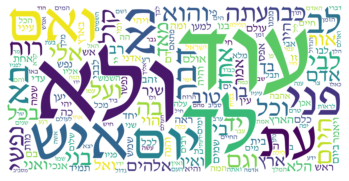

<Figure size 432x288 with 0 Axes>

In [6]:
from wordcloud import WordCloud
from heb_stop_words import STOP_WORDS # using spaCy hebrew stop words
WORD_CLOUD_FONT_PATH = Path("C:") / "WindowsFonts" / "david.ttf"

def create_word_cloud_from_corpus(poems: pd.Series, png_output: Path):
    stop_words = set(invert_words(STOP_WORDS))
    wordcloud = WordCloud(font_path=str(WORD_CLOUD_FONT_PATH), width=2000, height=1000, stopwords=stop_words,
                          background_color="white")
    wordcloud.generate(" ".join(text[::-1] for text in poems))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    wordcloud.to_file(png_output)
    return plt.figure()

create_word_cloud_from_corpus(df.content, OUTPUT_DIR_PATH / "corpus_word_cloud.png")

### Words and sentences

In [6]:
def most_common_words(texts: pd.Series, n: int, text_output_path: Path, stopwords: set = None):
    if stopwords is None:
	    stopwords = set()
    words_counter = Counter()
    for text in texts:
        for word in text_to_word_list(text):
            if word not in stopwords:
                words_counter[word] += 1
    sorted_word_count = sorted(words_counter.items(), key=lambda x:x[1], reverse=True)
    with open(text_output_path, 'w', encoding='utf-8') as f:
        for item in sorted_word_count:
            f.write(item[0] + " : " + str(item[1]))
            f.write("\n")
    words, count = zip(*sorted_word_count[:n])
    words = invert_words(words)
    fig = plt.figure(figsize=(15,10))
    return plt.bar(words, count)

Most common words in all the data set:


<BarContainer object of 15 artists>

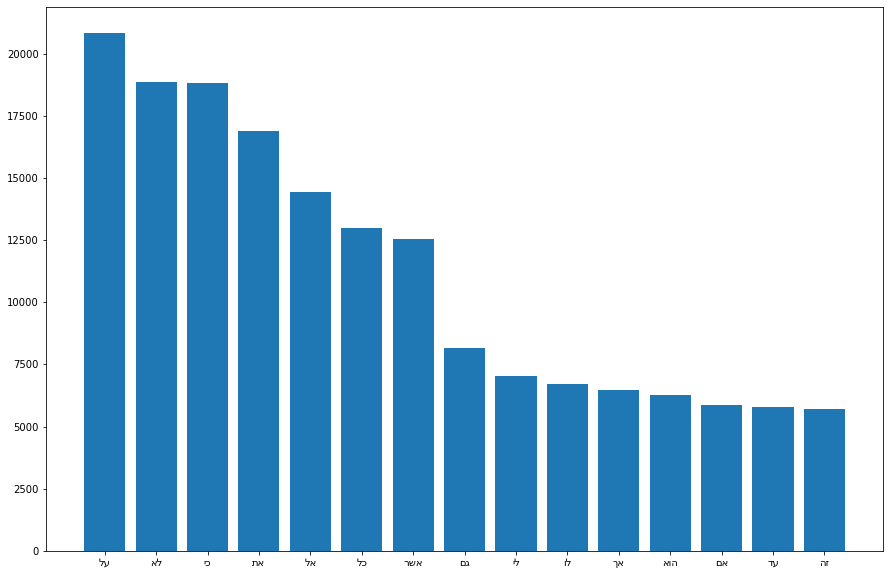

In [7]:
N = 15
print("Most common words in all the data set:")
most_common_words(df.content, 15, OUTPUT_DIR_PATH / "words_count_all_text.txt")

Most common words in all the data set without stopwords:


<BarContainer object of 15 artists>

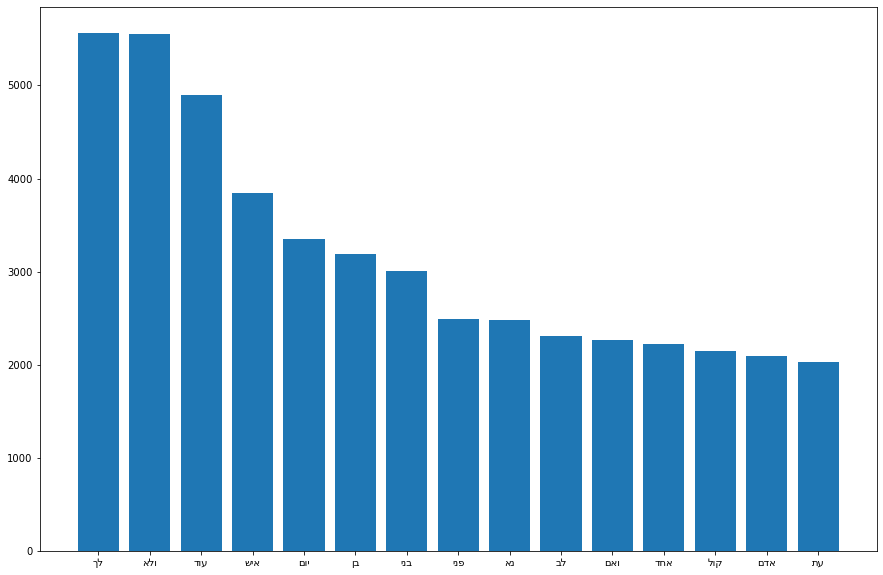

In [8]:
print("Most common words in all the data set without stopwords:")
most_common_words(df.content, 15, OUTPUT_DIR_PATH / "words_count_all_text_wo_stopwords.txt", STOP_WORDS)

<AxesSubplot:>

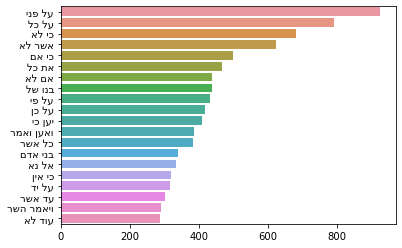

In [19]:
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer

def most_common_ngrams(texts: pd.Series, n: int=2, m: int=15, stopwords: set = None):
    if stopwords is None:
        stopwords = set()
    vec = CountVectorizer(ngram_range=(n, n)).fit(texts)
    bag_of_words = vec.transform(texts)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx])
                    for word, idx in vec.vocabulary_.items()]
    if stopwords:
        words_freq = [item for item in words_freq if all(w not in stopwords for w in item[0].split())]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)[:m]
    words, count = map(list,zip(*words_freq))
    return sns.barplot(x=count,y=invert_words(words))

<AxesSubplot:>

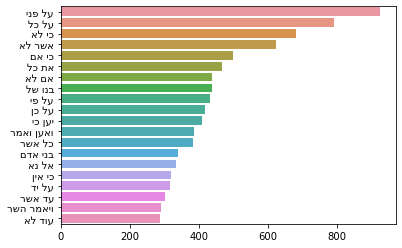

In [20]:
most_common_ngrams(df.content, 2, 20)

<AxesSubplot:>

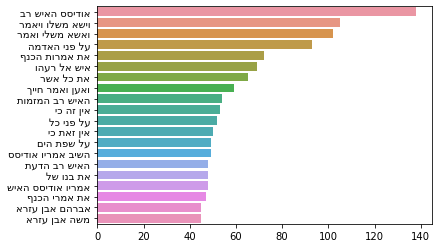

In [21]:
most_common_ngrams(df.content, 3, 20)

In [9]:
def plot_word_number_histogram(text: pd.Series):
    return text.map(lambda x: len(text_to_word_list(x))).hist(bins=50)

In total there 1,754,486 words in all the poems.
249.856 words in poem at average and std of 2053.497.

At most there 116,224 words - at song איליאדה by הומרוס
At least there 3 words - at song  by
Histogram of words count:


<AxesSubplot:>

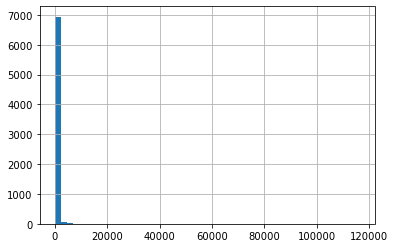

In [20]:
print(f"In total there {sum(df.words_count):,} words in all the poems.\n"
      f"{df.words_count.mean():.3f} words in poem at average and std of {df.words_count.std():.3f}.")
max_words = df.loc[df.words_count == df.words_count.max()]
print(f"At most there {df.words_count.max():,} words - at song {max_words.title.iat[0]} by {max_words.author.iat[0]}\n"
      f"Histogram of words count:")
plot_word_number_histogram(df.content)
#df.to_csv(OUTPUT_DIR_PATH / "words_count.csv", columns=["ID","title","authors","genre","words_count"])

Not all poems can be divided into sentences, because there are some whose structure that doesn't use sentences.
That is why there 1,608 that we count them with only one sentence 23.00%.Nevertheless, there 97,939 sentences in dataset (according to our basic sentences separator function).
14.011 sentences at average at poem and std of 115.416
At most there 5,246 sentences - at poem איליאדה by הומרוס
Histogram of sentences count:


<AxesSubplot:>

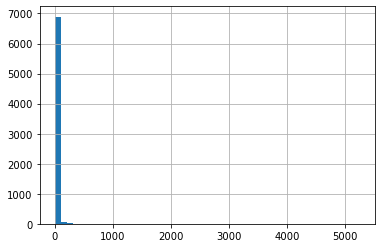

In [13]:
df["sentences_count"] = df.content_sep.map(len)
print(f"Not all poems can be divided into sentences, because there are some whose structure that doesn't use sentences.\n"
      f"That is why there {sum(df.sentences_count == 1):,} poems that we count them with only one sentence ({float(sum(df.sentences_count == 1))/df.shape[0]:.2%})\n."
      f"Nevertheless, there {sum(df.sentences_count):,} sentences in dataset (according to our basic sentences separator function).\n"
      f"{df.sentences_count.mean():.3f} sentences at average at poem and std of {df.sentences_count.std():.3f}.")
max_sentences = df.loc[df.sentences_count == df.sentences_count.max()]
print(f"At most there {df.sentences_count.max():,} sentences - at poem {max_sentences.title.iat[0]} by {max_sentences.author.iat[0]}.\n"
      f"Histogram of sentences count:")
df.sentences_count.hist(bins=50)

In [13]:
from dateutil import parser

def get_year(year_str):
    try:
        if year_str and year_str is not np.nan:
            if '0000' in year_str:
                return 0
            return parser.parse(year_str).year
    except:
        return None

israel_cities = {"Tel Aviv", "Jaffa", "Jerusalem", "Haifa", "Nahalal", "Acre", "Ramat Gan", "Givat Hashlosha",
                 "Rishon LeZion", "Petah Tikva", "Zikhron Ya'akov", "Israel", "Mandatory Palestine"}
ancient_period = range(-2000, 500)
spain_period = range(500, 1400)
renaissance_period = range(1400, 1800)
nineteenth_century = range(1800, 1900)
twentieth_century = range(1900, 2000)
modern_times = range(2000, 2100)

def parse_authors(df : pd.DataFrame, cities : set):
    df["hebrew_speaker"] = df["Hebrew Speaker"].fillna(True).apply(lambda x: 1 if x else 0)
    df["p_birth_israel"] = df["p_birth"].apply(lambda x: 1 if x in cities else 0)
    df["p_death_israel"] = df["p_death"].apply(lambda x: 1 if x in cities else 0)
    birth_year = []
    death_year = []
    for index, row in df.iterrows():
        birth_year.append(get_year(row["d_birth"]))
        death_year.append(get_year(row["d_death"]))
        if birth_year[-1] is None or death_year[-1] is None:
            print(f"{row.name} don't have valid birth or death date.")
    df["b_year"] = birth_year
    df["d_year"] = death_year

    df["b_ancient"] = df["b_year"].apply(lambda x: 1 if x in ancient_period else 0)
    df["b_spain"] = df["b_year"].apply(lambda x: 1 if x in spain_period else 0)
    df["b_renaissance"] = df["b_year"].apply(lambda x: 1 if x in renaissance_period else 0)
    df["b_19ct"] = df["b_year"].apply(lambda x: 1 if x in nineteenth_century else 0)
    df["b_20ct"] = df["b_year"].apply(lambda x: 1 if x in twentieth_century else 0)
    df["b_modern"] = df["b_year"].apply(lambda x: 1 if x in modern_times else 0)

    df["d_ancient"] = df["d_year"].apply(lambda x: 1 if x in ancient_period else 0)
    df["d_spain"] = df["d_year"].apply(lambda x: 1 if x in spain_period else 0)
    df["d_renaissance"] = df["d_year"].apply(lambda x: 1 if x in renaissance_period else 0)
    df["d_19ct"] = df["d_year"].apply(lambda x: 1 if x in nineteenth_century else 0)
    df["d_20ct"] = df["d_year"].apply(lambda x: 1 if x in twentieth_century else 0)
    df["d_modern"] = df["d_year"].apply(lambda x: 1 if x in modern_times else 0)
    return df

In [14]:
from corpus_processing import DATA_PATH
authors_stats_df_path = DATA_PATH / Path("authors_processed/authors_stats.pkl.gz")

authors_data_frame = pd.read_pickle(authors_stats_df_path).drop(columns=["songs_count", "sentence_count", "words_count", "words_total", "words_mean", "sentence_total", "sentence_mean"])
data = parse_authors(authors_data_frame,israel_cities)
authors_data_frame.head(10)

אלמוני/ת don't have valid birth or death date.
יוסף בן שמואל צרפתי don't have valid birth or death date.
יצחק בעל “עזרת נשים” don't have valid birth or death date.
חיא don't have valid birth or death date.
אינוקנטי אננסקי don't have valid birth or death date.


,id,sex,p_birth,p_death,d_birth,d_death,Hebrew Speaker,hebrew_speaker,p_birth_israel,p_death_israel,...,b_renaissance,b_19ct,b_20ct,b_modern,d_ancient,d_spain,d_renaissance,d_19ct,d_20ct,d_modern
הומרוס,195,male,Smyrna$$$$$$$$1 reference$$$$$$stated in$$$$$F...,Ios$$$$$$$$1 reference$$$$$$imported from Wiki...,0000-08-05,0000-08-05,False,0,0,0,...,0,0,0,0,1,0,0,0,0,0
שאול טשרניחובסקי,16,male,Mykhailivka,Jerusalem,1875-08-20,1943-10-14,NaN,1,0,1,...,0,1,0,0,0,0,0,0,1,0
עמנואל הרומי,107,male,Rome,Fermo,1260-01-01,1328-01-01,NaN,1,0,0,...,0,0,0,0,0,1,0,0,0,0
שלמה אבן גבירול,40,male,M?laga,Valencia,1021-01-01,11/18/1057,NaN,1,0,0,...,0,0,0,0,0,1,0,0,0,0
אברהם אבן עזרא,46,male,Tudela,Tudela,1089-01-01,1167-10-15,NaN,1,0,0,...,0,0,0,0,0,1,0,0,0,0
יהודה ליב גורדון,2,male,Vilnius,Saint Petersburg,1830-12-07,1892-09-16,NaN,1,0,0,...,0,1,0,0,0,0,0,1,0,0
יהודה הלוי,26,male,Tudela,Jerusalem,1079-01-01,1141-01-01,NaN,1,0,1,...,0,0,0,0,0,1,0,0,0,0
ג'ון מילטון,397,male,Cheapside$$$$$$$$located in the administrative...,London,1608-01-01,1674-01-01,False,0,0,0,...,1,0,0,0,0,0,1,0,0,0
חיים נחמן ביאליק,6,male,Hrada,Vienna,1873-12-07,1934-07-04,NaN,1,0,0,...,0,1,0,0,0,0,0,0,1,0
שמואל הנגיד,32,male,C?rdoba,Granada,0933-06-09,1055-06-09,NaN,1,0,0,...,0,0,0,0,0,1,0,0,0,0


In [15]:
# combine the authors data with songs data

combined_df = df.merge(authors_data_frame, how="left", right_index=True, left_on="authors")
combined_df.head(10)

,index,ID,path,title,authors,translators,original_language,genre,source_edition,content,...,b_renaissance,b_19ct,b_20ct,b_modern,d_ancient,d_spain,d_renaissance,d_19ct,d_20ct,d_modern
0,2,16,/p46/m16,לידידי הרב החכם רב-הפעלים,יהודה ליב גורדון,NaN,NaN,שירה,NaN,\t \t \t לידידי הרב החכם רב-הפעלים מ...,...,0,1,0,0,0,0,0,1,0,0
1,5,19,/p141/m19,הֲלָךְ נֶפֶשׁ,רחל בלובשטיין,NaN,NaN,שירה,NaN,\t \t \t לא. ד. גורדון היום הלך ו...,...,0,1,0,0,0,0,0,0,1,0
2,6,20,/p89/m20,אל הציפור,חיים נחמן ביאליק,NaN,NaN,שירה,NaN,"\t \t \t שלום רב שובך, צפרה נחמדת, מאר...",...,0,1,0,0,0,0,0,0,1,0
3,7,21,/p89/m21,מִשּׁוּט בַּמֶּרְחַקִּים,חיים נחמן ביאליק,NaN,NaN,שירה,NaN,"\t \t \t משוט במרחקים, ממקומות נדדתי, ...",...,0,1,0,0,0,0,0,0,1,0
4,8,22,/p67/m22,בורגני וחלוץ עני: זמר לעם,קדיש יהודה סילמן,NaN,NaN,שירה,NaN,\t \t \t לשיר בנגון אקדמות אלף – אבטיח...,...,0,1,0,0,0,0,0,0,1,0
5,9,23,/p89/m23,הִרְהוּרֵי לָיְלָה,חיים נחמן ביאליק,NaN,NaN,שירה,NaN,\t \t \t ידעתי כי בכיי –בכי כוס בין חרב...,...,0,1,0,0,0,0,0,0,1,0
6,10,24,/p89/m24,על אילת השחר,חיים נחמן ביאליק,NaN,NaN,שירה,NaN,\t \t \t מאורה על־פי נוסח ספרד נחש...,...,0,1,0,0,0,0,0,0,1,0
7,11,25,/p89/m25,בִּתְשׁוּבָתִי,חיים נחמן ביאליק,NaN,NaN,שירה,NaN,"\t \t \t שוב לפני: זקן בלה, פנים צמקים...",...,0,1,0,0,0,0,0,0,1,0
8,14,31,/p14/m31,[שד הרמון],אברהם שטרן,NaN,NaN,שירה,NaN,\t \t \t שד הרמון הכף עפקת. הגו נצמד...,...,0,0,1,0,0,0,0,0,1,0
9,15,32,/p170/m32,[כִּסְעִיף הֲדַס תִּטֶּה צְבִיָּה],משה אבן עזרא,NaN,NaN,שירה,NaN,\t \t \t כסעיף הדס תטה צביה עת / תרקד ו...,...,0,0,0,0,0,1,0,0,0,0


In [17]:
# some periods data:
print(f"The total number of songs {combined_df.shape[0]}\n"
      f"The number of songs from ancient period {combined_df.b_ancient.sum()} - {combined_df.d_ancient.sum()}\n"
      f"The number of songs from spain period {combined_df.b_spain.sum()} - {combined_df.d_spain.sum()}\n"
      f"The number of songs from renaissance period {combined_df.b_renaissance.sum()} - {combined_df.d_renaissance.sum()}\n"
      f"The number of songs from 19ct period {combined_df.b_19ct.sum()} - {combined_df.d_19ct.sum()}\n"
      f"The number of songs from 20ct period {combined_df.b_20ct.sum()} - {combined_df.d_20ct.sum()}\n"
      f"The number of songs from modern period {combined_df.b_modern.sum()} - {combined_df.d_modern.sum()}")

The total number of songs 7022
The number of songs from ancient period 40 - 40
The number of songs from spain period 3051 - 2908
The number of songs from renaissance period 402 - 396
The number of songs from 19ct period 3139 - 579
The number of songs from 20ct period 357 - 3064
The number of songs from modern period 0 - 1


## test data on with twentieth_century songs

In [1]:
from sklearn.model_selection import train_test_split

X = combined_df.content
y = combined_df.d_renaissance

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)
print(f"Test set has {len(X_train)} samples, and test have {len(X_test)}")
print(f"In train set there {y_train.sum()} songs from renaissance\n"
      f"In test set there {y_test.sum()} songs from renaissance")

NameError: name 'combined_df' is not defined

## run the pipeline:

In [21]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import plot_confusion_matrix
import matplotlib.pyplot as plt

vectorizer=CountVectorizer(ngram_range=(1,2))
transformer=TfidfTransformer(use_idf=False)
algo=RandomForestClassifier()

pipe = Pipeline([('vectorizer', vectorizer),
                 ('transformer', transformer),
                 #('feature_select', SelectKBest(chi2, k=20000)),
                 ('algo', algo)])

pipe.fit(X_train, y_train)
prediction = pipe.predict(X_test)
plot_confusion_matrix(pipe, X_test, y_test)
plt.show()

C:\ProgramData\Anaconda3\envs\final_project\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


ValueError: Input contains NaN

In [ ]:
# try XGBoost https://xgboost.readthedocs.io/en/latest/python/python_api.html


